## Goal - Detect Live Photo Vs Screengrab

In [ ]:
#Installing Requirements
!pip install tensorflow opencv-python matplotlib # tensorflow-gpu seems to be depreciated from 2.1

In [ ]:
#Check Installed Dependencies
!pip list

In [13]:
#Importing dependencies

import tensorflow as tf
import os
import timeit
from matplotlib import pyplot as plt
import numpy as np


In [ ]:
##Getting GPU's fired #Using Colab GPU's to Run GPU
#Check and List Available GPU's First

gpus= tf.config.experimental.list_physical_devices('GPU')
cpus= tf.config.experimental.list_physical_devices('CPU')
print(gpus) # To Check available GPU's for consumption
print(cpus) # To Check available GPU's for consumption
gpus= tf.device('/device:GPU:0')

Creating a Dataset where Live Photos are available, Creating another Sample Data set manually which takes photo of the Image

In [15]:
#importing Opencv Libraries for image viewing
import cv2
import imghdr


In [16]:
#Creating variable for Data Path
data_dir= "/content/drive/MyDrive/Projects/Fraud-Risk-Model-Live-Photo/data"

In [17]:
image_exts= ['jpeg','jpg','bmp','png']

In [18]:
os.listdir(data_dir) #checking directory

['screengrab', 'live']

In [19]:
#checking image availability Picking a random image from data

img= cv2.imread(os.path.join('drive','MyDrive','Projects','Fraud-Risk-Model-Live-Photo','data','live','800px_COLOURBOX18644360.jpg'))

In [20]:
img.shape #3 Channels=Coloured image

(800, 489, 3)

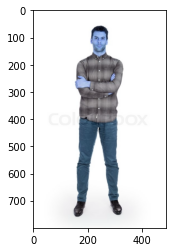

In [21]:
# Printing matplotlib object

#wierd colours due to opencv reading image as BGR whereas matplotlib expects rgb
plt.imshow(img)

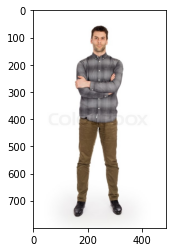

In [22]:
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB)) #Correcting channels

In [23]:
# os.listdir(os.path.join(data_dir,'live')) checking image availability

#Looping through Images

for image_class in os.listdir(data_dir):
  for image in os.listdir(os.path.join(data_dir, image_class)):
    image_path= os.path.join(data_dir,image_class,image)
    try:
      img= cv2.imread(image_path)
      tip= imghdr.what(image_path)
      if tip not in image_exts:
        print('Image is not in List of image formats')
        os.remove(image_path)
    except Exception as e:
      print('issue with Image{}'.format(image_path))
      


In [24]:
#Load Data by building a data Generator pipeline to prevent memory hogging

#tf.data.Dataset.list_files

data= tf.keras.utils.image_dataset_from_directory('drive/MyDrive/Projects/Fraud-Risk-Model-Live-Photo/data',batch_size= 6)

Found 103 files belonging to 2 classes.


In [25]:
#Creating a data iterator

data_iterator = data.as_numpy_iterator()


In [26]:
#creating batches for iteration

batch= data_iterator.next()

In [27]:
len(batch) # 2 part Tuple with Images and labels

2

In [28]:
#creating images as numpy arrays
batch[0].shape #Auto Scaling done by keras

(6, 256, 256, 3)

In [29]:
# class 1 = screengrab, class 0 = livephoto
batch[1]

array([1, 1, 0, 0, 0, 1], dtype=int32)

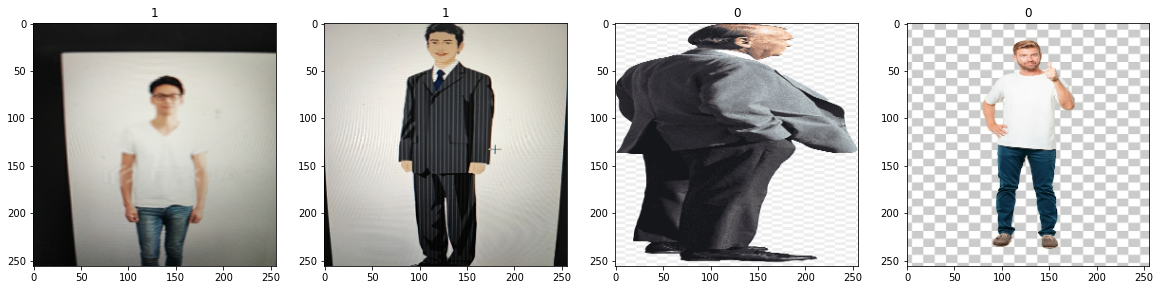

In [30]:
#visualize classes

fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

Preprocessing Data

In [31]:
#Scale Data

print(batch[0].max())
print(batch[0].min())

255.0
0.0


In [32]:
#preprocessing/scaling down data in data pipeline before pre-fectch
data = data.map(lambda x,y: (x/255, y))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [33]:
data.as_numpy_iterator().next()

(array([[[[0.9607843 , 0.9607843 , 0.9607843 ],
          [0.96345776, 0.96345776, 0.96345776],
          [0.9647059 , 0.9647059 , 0.9647059 ],
          ...,
          [0.9607843 , 0.9607843 , 0.9607843 ],
          [0.9607843 , 0.9607843 , 0.9607843 ],
          [0.9607843 , 0.9607843 , 0.9607843 ]],
 
         [[0.9647059 , 0.9647059 , 0.9647059 ],
          [0.9647059 , 0.9647059 , 0.9647059 ],
          [0.9647059 , 0.9647059 , 0.9647059 ],
          ...,
          [0.9607843 , 0.9607843 , 0.9607843 ],
          [0.9607843 , 0.9607843 , 0.9607843 ],
          [0.9607843 , 0.9607843 , 0.9607843 ]],
 
         [[0.9647059 , 0.9647059 , 0.9647059 ],
          [0.9647059 , 0.9647059 , 0.9647059 ],
          [0.9647059 , 0.9647059 , 0.9647059 ],
          ...,
          [0.9607843 , 0.9607843 , 0.9607843 ],
          [0.9607843 , 0.9607843 , 0.9607843 ],
          [0.9624331 , 0.9624331 , 0.9624331 ]],
 
         ...,
 
         [[0.9647059 , 0.95686275, 0.9607843 ],
          [0.96470

In [34]:
# split data
len(data)


18

In [35]:
train_size= int(len(data)*.7)
val_size= int(len(data)*.2)+1
test_size= int(len(data)*.1)+1

In [36]:
print(train_size)
print(val_size)
print(test_size)

12
4
2


In [37]:
train_size+val_size+test_size

18

In [38]:
train= data.take(train_size)
val = data.skip(train_size).take(val_size)
test= data.skip(train_size+val_size).take(test_size)

In [39]:
print(len(train))
print(len(val))
print(len(test))

12
4
2


Building Model

In [40]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten



In [41]:
model= Sequential()

In [42]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [43]:
model.compile('adam',loss= tf.losses.BinaryCrossentropy(),metrics=['accuracy']) #https://www.tensorflow.org/api_docs/python/tf/keras/optimizers

In [44]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

Train

In [45]:
logdir= '/content/drive/MyDrive/Projects/Fraud-Risk-Model-Live-Photo/logs'

In [46]:
# Log model training to guauge performance, Drop learning rate or not
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [47]:
hist= model.fit(train,epochs=20,validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
12/12 [==============================] - 10s 721ms/step - loss: 1.0953 - accuracy: 0.5000 - val_loss: 0.6095 - val_accuracy: 0.7500
Epoch 2/20
12/12 [==============================] - 8s 613ms/step - loss: 0.6411 - accuracy: 0.6667 - val_loss: 0.5602 - val_accuracy: 0.7083
Epoch 3/20
12/12 [==============================] - 7s 483ms/step - loss: 0.4560 - accuracy: 0.8889 - val_loss: 0.3317 - val_accuracy: 0.8333
Epoch 4/20
12/12 [==============================] - 7s 590ms/step - loss: 0.4434 - accuracy: 0.8194 - val_loss: 0.3514 - val_accuracy: 0.7917
Epoch 5/20
12/12 [==============================] - 9s 719ms/step - loss: 0.1779 - accuracy: 0.9722 - val_loss: 0.0957 - val_accuracy: 1.0000
Epoch 6/20
12/12 [==============================] - 7s 514ms/step - loss: 0.0781 - accuracy: 0.9861 - val_loss: 0.0566 - val_accuracy: 1.0000
Epoch 7/20
12/12 [==============================] - 8s 638ms/step - loss: 0.1109 - accuracy: 0.9722 - val_loss: 0.0407 - val_accuracy: 1.0000
Epoch

In [48]:
hist.history

{'loss': [1.095294713973999,
  0.6411426067352295,
  0.45597854256629944,
  0.4433813691139221,
  0.1779107302427292,
  0.07806326448917389,
  0.11085245013237,
  0.07074536383152008,
  0.07358545809984207,
  0.013844868168234825,
  0.003187537658959627,
  0.0010813535191118717,
  0.0008447186555713415,
  0.00047155754873529077,
  0.00020458383369259536,
  0.0005727738607674837,
  0.00029381836066022515,
  0.0005489729810506105,
  0.00022589851869270205,
  0.0012824037112295628],
 'accuracy': [0.5,
  0.6666666865348816,
  0.8888888955116272,
  0.8194444179534912,
  0.9722222089767456,
  0.9861111044883728,
  0.9722222089767456,
  0.9861111044883728,
  0.9722222089767456,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0],
 'val_loss': [0.609533965587616,
  0.5602120757102966,
  0.3316723704338074,
  0.3513984978199005,
  0.09572427719831467,
  0.056617990136146545,
  0.04073436185717583,
  0.017142480239272118,
  0.11670491844415665,
  0.006943055894225836,
  

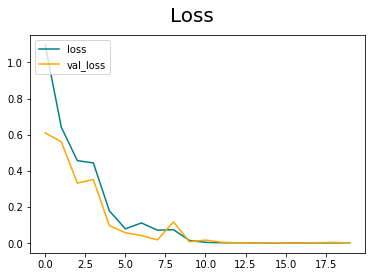

In [49]:
#Plotting Performance
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

Evaluating Performance

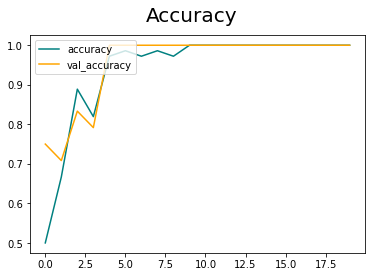

In [50]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

#Evaluate performance by checking precision, recall and accuracy


In [53]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [54]:
pre =Precision()
re= Recall()
acc= BinaryAccuracy()

In [55]:
len(test)

2

In [56]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 77ms/step


In [63]:
print(f'Precision:{pre.result().numpy()},Recall:{ re.result().numpy()},Accuracy:{ acc.result().numpy()}')

Precision:1.0,Recall:1.0,Accuracy:1.0


Testing Model

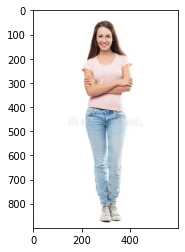

In [76]:
img= cv2.imread('/content/drive/MyDrive/Projects/Fraud-Risk-Model-Live-Photo/livetest.jpg')
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.show()

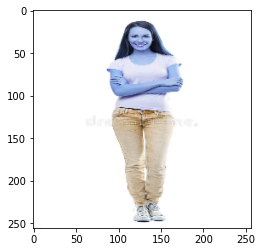

In [77]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [78]:
np.expand_dims(resize,0).shape

(1, 256, 256, 3)

In [79]:
yhat= model.predict(np.expand_dims(resize/255,0))

1/1 [==============================] - 0s 47ms/step


In [80]:
yhat # class 1 = screengrab, class 0 = livephoto

array([[0.00023096]], dtype=float32)

In [81]:
if yhat > 0.5: 
    print(f'Predicted class is screengrab')
else:
    print(f'Predicted class is livephoto')

Predicted class is livephoto


Saving the Model for Future of Deployment

In [82]:
model.save(os.path.join('/content/drive/MyDrive/Projects/Fraud-Risk-Model-Live-Photo/models','liveornotlive.h5')) #serializing model

In [83]:
from tensorflow.keras.models import load_model

In [85]:
new_model= load_model(os.path.join('/content/drive/MyDrive/Projects/Fraud-Risk-Model-Live-Photo/models','liveornotlive.h5'))

In [86]:
new_model

In [88]:
yhatnew= new_model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 40ms/step


In [89]:
if yhat > 0.5: 
    print(f'Predicted class is screengrab')
else:
    print(f'Predicted class is livephoto')

Predicted class is livephoto
